In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

%matplotlib inline
sns.set(style="white", color_codes=True)

/usr/local/lib/python3.5/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Genotypes simulation algorithm

Рассмотрим следующую простую модель. Пусть есть два биаллельных ОНП $A$ и $B$ с аллелями $a_1$, $a_2$, и $b_1$, $b_2$ соответственно. 
Параметры модели: $P(a_1)$ -- частота аллеля $a_1$ в ОНП $A$, $P(b_1)$ -- частота аллеля $b_1$ в ОНП $B$, $N$ -- число индивидов в популяции, $r$ -- коэффициент корреляции между снипами.
Запишем выражение для коэффициента неравновесия по сцеплению через частоты всех возможных пар аллелей:

$$ D = P(a_1 b_1) - P(a_1) P(b_1) $$ 
$$ -D = P(a_1 b_2) - P(a_1) P(b_2) $$ 
$$ -D = P(a_2 b_1) - P(a_2) P(b_1) $$ 
$$ D = P(a_2 b_2) - P(a_2) P(b_2) $$

Из этой системы уравнений можно выразить вероятности гаплотипов:

|       |               $b_1$              |               $b_2$              |
|:-----:|:--------------------------------:|:--------------------------------:|
| $a_1$ | $P(a_1 b_1) = P(a_1) P(b_1) + D$ | $P(a_1 b_2) = P(a_1) P(b_2) - D$ |
| $a_2$ | $P(a_2 b_1) = P(a_2) P(b_1) - D$ | $P(a_2 b_2) = P(a_2) P(b_2) + D$ |

Теперь, когда известно распределение вероятностей гаплотипов, сгенерируем $2N$ гаплотипов и случайным образом объединив их пары, получим $N$ генотипов.

# Genotypes simulation algorithm implementation

### Setting parameters

In [2]:
population_size = 100000  # number of individuals in population

freq_a1 = 0.7           # allele frequency of the first allele in first site
freq_a2 = 1 - freq_a1    # allele frequency of the second allele in first site 

freq_b1 = 0.6            # allele frequency of the first allele in second site
freq_b2 = 1 - freq_b1    # allele frequency of the second allele in second site

r = 0.7                # absolute value should not be more than 0.2 (??)
d = r * np.sqrt(freq_a1 * freq_a2 * freq_b1 * freq_b2)
print("d =", d)

d = 0.157149610245


### Calculating probabilities of haplotypes

In [3]:
p_a1_b1 = d + freq_a1 * freq_b1
p_a1_b2 = -d + freq_a1 * freq_b2
p_a2_b1 = -d + freq_a2 * freq_b1
p_a2_b2 = d + freq_a2 * freq_b2  # 1 - p_a1_b1 - p_a1_b2 - p_a2_b1

if 0.0 <= p_a1_b1 <= 1.0 and \
   0.0 <= p_a1_b2 <= 1.0 and \
   0.0 <= p_a2_b1 <= 1.0 and \
   0.0 <= p_a2_b2 <= 1.0:
        
    print("p_a1_b1 =", p_a1_b1)
    print("p_a1_b2 =", p_a1_b2)
    print("p_a2_b1 =", p_a2_b1)
    print("p_a2_b2 =", p_a2_b2)
    
else:
    
    print("incorrect input")
    
# plot d from r and p_ai_bj, найти множество допустимых значений

p_a1_b1 = 0.577149610245
p_a1_b2 = 0.122850389755
p_a2_b1 = 0.0228503897555
p_a2_b2 = 0.277149610245


### Generating haplotypes

In [4]:
haplotypes = []

for counter in range(2 * population_size):
    
    x = float(np.random.uniform(0, 1, 1))
    if x < p_a1_b1:
        haplotypes.append(11)
    elif x < p_a1_b1 + p_a1_b2:
        haplotypes.append(12)
    elif x < p_a1_b1 + p_a1_b2 + p_a2_b1:
        haplotypes.append(21)
    else:
        haplotypes.append(22)

### Generating genotypes

In [5]:
genotypes = []

for i in range(population_size):
    genotype = str(haplotypes[i] // 10 + haplotypes[i + population_size] // 10 - 2)
    genotype += str(haplotypes[i] % 10 + haplotypes[i + population_size] % 10 - 2)
    genotypes.append(genotype)

genotypes = np.array([list(i) for i in genotypes], dtype='int') 

mse_genotypes_a = np.mean((genotypes[:, 0] - np.mean(genotypes[:, 0])) ** 2)
mse_genotypes_b = np.mean((genotypes[:, 1] - np.mean(genotypes[:, 1])) ** 2)

print(mse_genotypes_a, 2 * freq_a1 * freq_a2)
print(mse_genotypes_b, 2 * freq_b1 * freq_b2)

0.4210839936 0.42000000000000004
0.4811979951 0.48


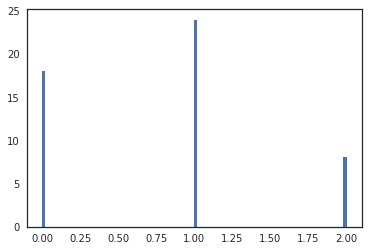

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
n, bins, rectangles = ax.hist(genotypes[:, 1], 100, normed=True)
fig.canvas.draw()
plt.show()

In [14]:
count_a, count_b = 0, 0

for i in range(population_size):
    count_a += genotypes[i][0]
    count_b += genotypes[i][1]

print("     Calc allele freq \t Exp allele freq")
print("A:  ", 1 - count_a / (2 * population_size), "\t\t", freq_a1)
print("B:  ", 1 - count_b / (2 * population_size), "\t\t", freq_b1)

     Calc allele freq 	 Exp allele freq
A:   0.69996 		 0.7
B:   0.599965 		 0.6


# Phenotypes simulation algorithm

Рассмотрим аддитивную модель с параметрами $\beta_A$ и $\beta_B$:

$a_1 a_1$    0  
$a_1 a_2$    $\beta_A$  
$a_2 a_2$    $2 \beta_A$  

$b_1 b_1$    0  
$b_1 b_2$    $\beta_B$  
$b_2 b_2$    $2 \beta_B$  

$\mathbf{y} = \mathbf{G} \mathbf{w} + \mathbf{\varepsilon}$

$\mathbf{y}$ -- вектор фенотипов,  
$\mathbf{G}$ -- матрица генотипов,  
$\mathbf{w}$ -- вектор весов,  
$\mathbf{\varepsilon}$ -- вектор ошибок, полученный из стандартного распределения

Пусть $\sigma_y = 1$, тогда, поскольку $\sigma_y = \sigma_{Gw} + \sigma_{\varepsilon}$,

$\sigma_{\varepsilon} = 1 - \sigma_{Gw}$

$ \sigma_{Gw} = \beta_1^2 mse_a + \beta_2^2 mse_b - 2 cov(\beta_1^2 mse_a, \beta_2^2 mse_b)$


# Phenotypes simulation algorithm implementation

### Setting parameters

In [15]:
beta_a = 0.15  # effect of heterozygote in the first snp on phenotype
beta_b = 0.13  # effect of heterozygote in the second snp on phenotype

In [21]:
phenotypes = []

sigma_err = 1 - mse_genotypes_a * beta_a ** 2 - mse_genotypes_b * beta_b ** 2

for i in range(population_size):
    phenotype = genotypes[i][0] * beta_a + genotypes[i][1] * beta_b + np.random.normal(0, np.sqrt(sigma_err))
    phenotypes.append(phenotype)

# test phenotypes mean and d 
# test against normal distr.

In [22]:
np.std(phenotypes)

1.0028685384037959

In [17]:
simulated_data = pd.DataFrame({"phenotype": phenotypes, 
                               "snp_a_gen": genotypes[:, 0], 
                               "snp_b_gen": genotypes[:, 1]})
simulated_data.head()

,phenotype,snp_a_gen,snp_b_gen
0,-0.543576,0,1
1,-1.237339,0,1
2,0.381033,1,0
3,-0.704838,1,2
4,-0.229729,0,0


gen_a = 0 , gen_b = 0 , mean = -0.004617011175153093
gen_a = 0 , gen_b = 1 , mean = 0.13084558883030362
gen_a = 0 , gen_b = 2 , mean = 0.2971367899934479
gen_a = 1 , gen_b = 0 , mean = 0.1513158824202622
gen_a = 1 , gen_b = 1 , mean = 0.28365252295784515
gen_a = 1 , gen_b = 2 , mean = 0.4038542094539864
gen_a = 2 , gen_b = 0 , mean = 0.2268785044655681
gen_a = 2 , gen_b = 1 , mean = 0.4227611735248942
gen_a = 2 , gen_b = 2 , mean = 0.5623698024850529
0.5623698024850529


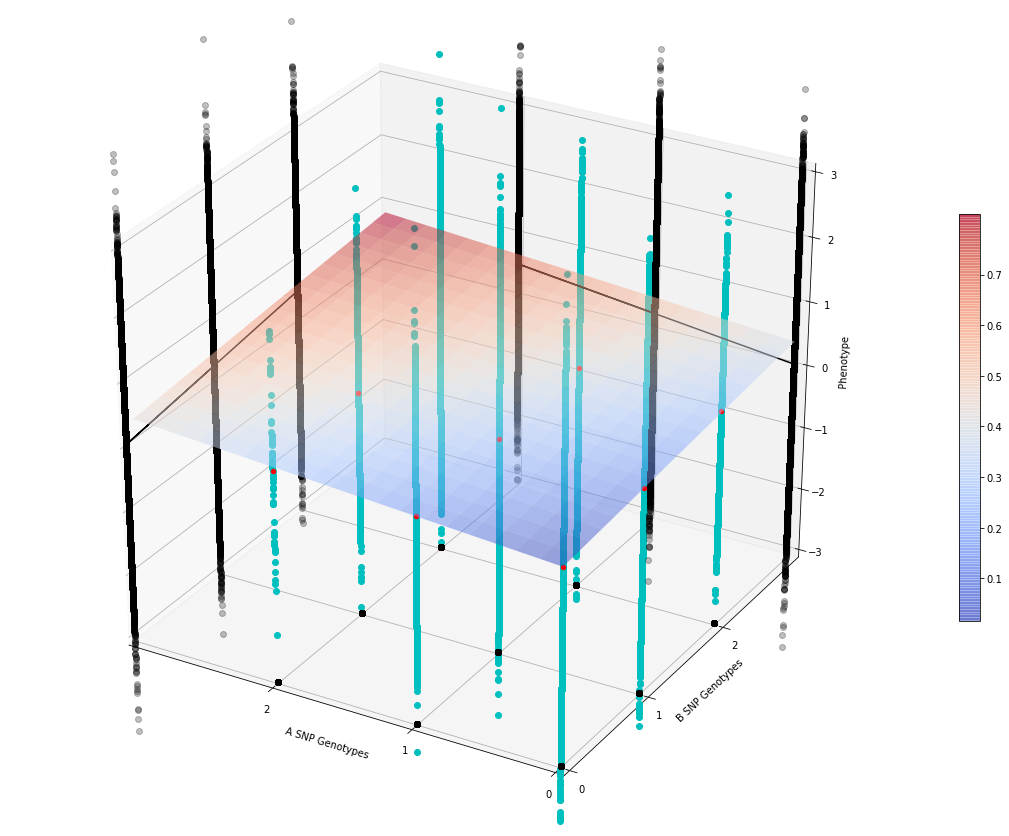

In [18]:
fig = plt.figure(figsize=(20, 15))
ax = fig.gca(projection="3d")

ax.plot(simulated_data.snp_a_gen, 
        simulated_data.snp_b_gen, 
        simulated_data.phenotype, 'co', zorder=0)

ax.plot(simulated_data.snp_a_gen, 
        simulated_data.phenotype, 
        'ko', zdir='y', alpha=0.25, zs=3.0, mec=None, zorder=0)

ax.plot(simulated_data.snp_b_gen, 
        simulated_data.phenotype, 
        'ko', zdir='x', alpha=0.25, zs=3.06, mec=None, zorder=0)

ax.plot(simulated_data.snp_a_gen,
        simulated_data.snp_b_gen,
        'ko', zdir='z', alpha=0.25, zs=-3.1, mec=None, zorder=0)

# adding plane
model = smf.ols('phenotype ~ snp_a_gen + snp_b_gen', data=simulated_data).fit()
# print(model.summary())
xx, yy = np.meshgrid(np.linspace(0, 3.0, 20), np.linspace(0, 3.0, 20))
zz = model.params[1] * xx + model.params[2] * yy + model.params[0]
plane = ax.plot_surface(xx, yy, zz, color='blue', alpha=0.5, cmap=cm.coolwarm, zorder=1)


fit_a = np.polyfit(simulated_data.snp_a_gen, 
                   simulated_data.phenotype, 
                   deg=1)
ax.plot(np.array(simulated_data.snp_a_gen), 
        fit_a[0] * np.array(simulated_data.snp_a_gen) + fit_a[1], 
        color='k', zdir='y', zs=3.0, zorder=1)

fit_b = np.polyfit(simulated_data.snp_b_gen, 
                   simulated_data.phenotype, 
                   deg=1)
ax.plot(np.array(simulated_data.snp_b_gen), 
        fit_b[0] * np.array(simulated_data.snp_b_gen) + fit_b[1], 
        color='k', zdir='x', zs=3.06, zorder=1)

for gen_a in range(3):
    for gen_b in range(3):
        print("gen_a =", gen_a, 
              ", gen_b =", gen_b, 
              ", mean =", simulated_data[(simulated_data.snp_a_gen == gen_a) & 
                                         (simulated_data.snp_b_gen == gen_b)].phenotype.mean())
        ax.scatter(xs=[gen_a], 
                   ys=[gen_b], 
                   zs=[simulated_data[(simulated_data.snp_a_gen == gen_a) & 
                                      (simulated_data.snp_b_gen == gen_b)].phenotype.mean()],
                   color='r',
                   zorder=10)

print(simulated_data[(simulated_data.snp_a_gen == 2) & 
                     (simulated_data.snp_b_gen == 2)].phenotype.mean())
        
for gen in range(3):
    
    ax.plot([gen], 
            [simulated_data[simulated_data.snp_a_gen == gen].phenotype.mean()], 
            color='k', 
            zdir='y', 
            zs=3.0,
            zorder=10)
    
    ax.plot([gen], 
            [simulated_data[simulated_data.snp_b_gen == gen].phenotype.mean()], 
            color='k', 
            zdir='x', 
            zs=3.0,
            zorder=10)

ax.set_xlabel("A SNP Genotypes")
ax.set_xlim(3.0, 0.0)

ax.set_ylabel('B SNP Genotypes')
ax.set_ylim(0.0, 3.0)

ax.set_zlabel("Phenotype")
ax.set_zlim(-3.0, 3.0)

ax.set_yticks(range(3))
ax.set_xticks(range(3))

fig.colorbar(plane, shrink=0.5, aspect=20, ticks=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])

# fig.savefig("./multivariate_regression_on_simulated_data.pdf", dpi=300)
# fig.savefig("./multivariate_regression_on_simulated_data.png", dpi=300)

plt.show()
plt.close(fig)

         z1        z2
0  8.049642  4.756826
1  8.157889  6.887383
2  7.552011  6.820614
3  5.460234  7.479007
4  8.014952  5.661308


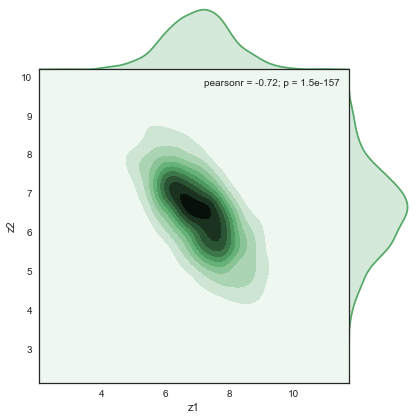

In [40]:
joint_z1_z2 = pd.read_csv("../out/1000_iter_z1_z2.csv", names="z1 z2".split())

print(joint_z1_z2.head())

g = sns.jointplot("z1", "z2", data=joint_z1_z2, kind="kde", space=0, color="g")
g.savefig("../out/joint_distr_z1_z2_1000_iter.png", dpi=300)
plt.show()